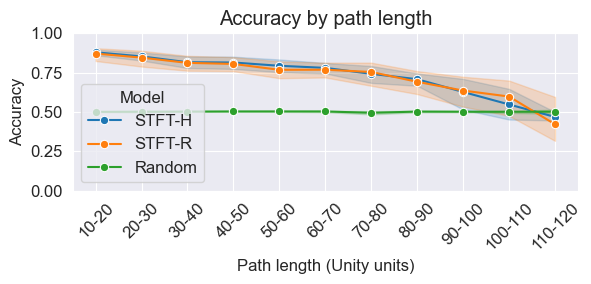

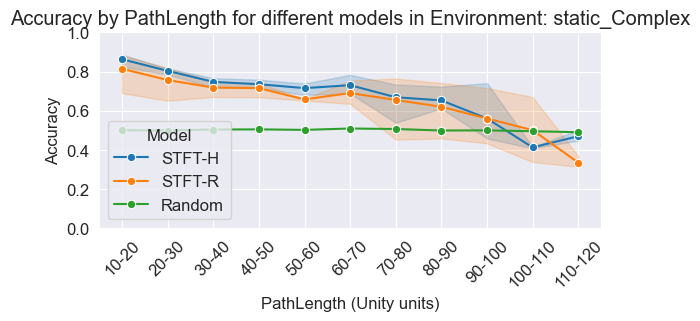

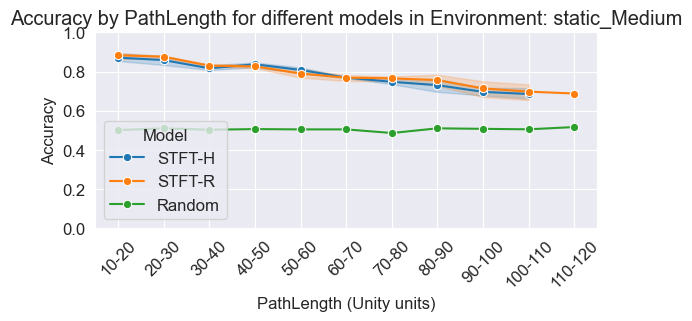

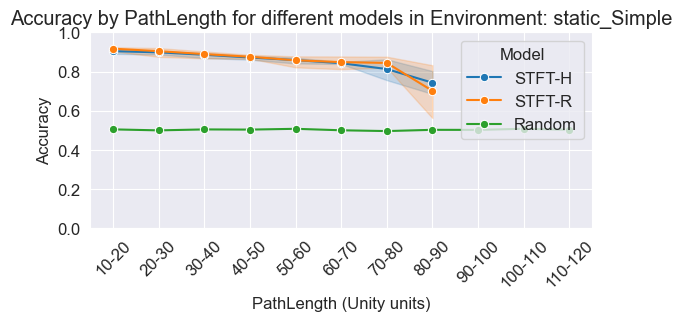

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from parse_name import parse_filename

base_path = r"../logs"
files = glob.glob(f"{base_path}/*.csv")
MAX_STEPS = 1000
spl_totals = []

# Define the bins and labels for PathLength
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
bin_labels = [f"{bins[i]}-{bins[i + 1]}" for i in range(len(bins) - 1)]


for file in files:
    metadata = parse_filename(file)
    df = pd.read_csv(file, sep=";", decimal=",")
    string_cols = ["ClipName"]
    for col in df.columns:
        if col not in string_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    shortest_path = df.groupby("Episode")["PathLength"].first()
    df["FullPath"] = shortest_path

    # Compute absolute difference for target angle and predicted angle
    df["Difference"] = (df["ActionAngle"] - df["AngleToTarget"]).abs()

    # Correct angles that wrap around
    df.loc[df["Difference"] > 1, "Difference"] = 2 - df["Difference"]

    # Compute difference to accuracy
    df["Accuracy"] = 1 - df["Difference"]

    # Bin the PathLength values
    df["PathLengthBin"] = pd.cut(df["PathLength"], bins=bins, labels=bin_labels, include_lowest=True)

    # Calculate accuracy for each PathLength bin
    accuracy = df.groupby("PathLengthBin", observed=True)["Accuracy"].mean()

    model = metadata.model
    if "rect" in model:
        model = "STFT-R"
    elif "hanning" in model:
        if "dynamic" in model:
            model = "STFT-H dynamic"
            continue
        else:
            model = "STFT-H"
    elif "random" in model:
        model = "Random"
    environment = metadata.scene

    for index, value in accuracy.items():
        if pd.notnull(index):  # Ensure index is not null
            spl_totals.append({"Environment": environment, "Model": model, "PathLengthBin": index, "Accuracy": value})

# Convert the list of dictionaries to a DataFrame
df_totals = pd.DataFrame(spl_totals)

font_size = 12
plt.rcParams.update({'font.size': font_size})

# Create combined plot for all envs
plt.figure(figsize=(6, 3))
hue_order = ["STFT-H", "STFT-R", "Random"]
sns.lineplot(data=df_totals, x="PathLengthBin", y="Accuracy", hue="Model",
             marker='o', hue_order=hue_order)
plt.title(f"Accuracy by path length")
plt.xlabel("Path length (Unity units)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.tight_layout()
plt.savefig(f"accuracy_by_pathlength.png")
plt.savefig(f"accuracy_by_pathlength.pdf")
plt.show()

# Get unique environments
environments = df_totals["Environment"].unique()

# Plot a line plot for each environment with seaborn
for env in environments:
    plt.figure(figsize=(6, 3))
    sns.lineplot(data=df_totals[df_totals["Environment"] == env], x="PathLengthBin", y="Accuracy", hue="Model",
                 marker='o', hue_order=hue_order)
    plt.title(f"Accuracy by PathLength for different models in Environment: {env}")
    plt.xlabel("PathLength (Unity units)")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotate x labels for better readability
    plt.savefig(f"accuracy_by_pathlength_{env}.png")
    plt.show()
